<p style='text-align: center'>
  <img src='https://ops.fhwa.dot.gov/publications/fhwahop18073/images/figure1.png' width='500' height=275/>
</p>

<div style='text-align:center'>
    <p style='font-family: Helvetica; font-size: 25px; color: rgb(0,125,183);'><strong>Convergence Analysis of Trip Distribution Methods</strong></p>
</div>

---

# <h1 style='background-color: rgb(0,125,183); padding: 21px; color: #FFFFFF; font-family: Helvetica; font-size: 25px'><b>I. Introduction</b></h1>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>Trip distribution is the step in a classical travel demand framework that takes zone-level trip productions (origins) and attractions (destinations) from the trip generation step and allocates these trips between specific origin-destination pairs. Its output is an origin–destination (OD) matrix (fig. ) that feeds modal choice and assignment models. In practical planning the OD matrix must respect two types of conservation: the sum of trips produced by a zone should equal the row total for that zone, and the sum of trips attracted to a zone should equal the column total. When both conditions are required the model is called doubly constrained; when one side is enforced it is singly constrained. The choice of method depends on data availability and planning objectives: growth-factor methods exploit knowledge of complete present O-D matrix and future zonal totals, while synthetic models (impedance and deterrence forms) rely on travel distance and/or cost information. Growth-factor methods are often used for scenarios where the spatial interaction pattern is governed by the growth rate from the present to future total trips generated and attracted per zone; synthetic methods are preferred when structural changes in costs, accessibility or land-use are included explicitly via an impedance or deterrence function.</p>
</div>

<p style='text-align: center'>
  <img src='../trip_distribution/images/dist_table.png' width='1150' height=225/>
</p>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>When the future O-D matrix has been populated, this is often visualized through desire lines overlayed on the study area (fig.).</p>
</div>

<p style='text-align: center'>
  <img src='../trip_distribution/images/desire_line.png' width='225' height=350/>
</p>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>This notebook implements and demonstrates nine commonly used methods - four in the growth-factor family (Average growth, Detroit, Fratar, Furness) and five in the synthetic family (Impedance generation-constrained, Impedance attraction-constrained, Deterrence exponential, Deterrence power, and Deterrence combined). Each method is described conceptually, followed immediately by a matrix-based worked example using a small 10-zone environment. Choosing 10 zones keeps the worked matrices short and easy to trace by hand, while still demonstrating the iterative mechanics clearly. For the synthetic methods we construct a simple travel distance-based (impedance) function and a chosen cost-based decay function (e.g., power or exponential) to form the deterrence factors.<br><br>Convergence is measured by determining the maximum ratio between the resulting to the forecasted future totals per respective zone covering both the generation and attraction, where iteration commonly stops upon reaching 5% (eq.).</p>
</div>

$$
\frac{G_{i}^{(k+1)}}{G_{i}^{(k)}} \leq 5\%\ (Generation\ constrained);\ \  \frac{A_{j}^{(k+1)}}{A_{j}^{(k)}} \leq 5\%\ (Attraction\ constrained)
$$

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>This notebook shows iteration tables, prints intermediate totals, and plots the per-iteration convergence indicator so you it can be visually inspected how quickly each method stabilizes. Where calibration parameters (𝛽 or α) are required for deterrence functions, we choose small example values to make the iterative behaviour apparent; in real practice these parameters are calibrated against survey data.<br><br>Ortúzar and Willumsen (2011)<a href='https://download.e-bookshelf.de/download/0000/5967/64/L-G-0000596764-0002364278.pdf' target='_blank' style='color: rgb(0,125,183); text-decoration:underline'>[1]</a> provided the theoretical foundations and recommended practice for many of these models. The goal is pedagogical clarity: after walking through each method you will see why some methods converge rapidly, why some oscillate, and what trade-offs the modeller must consider when selecting a distribution routine for a given project.</p>
</div>

---

# <h1 style='background-color: rgb(0,125,183); padding: 21px;font-family: Helvetica; font-size: 25px'>**II. Importing libraries**</h1>

In [1]:
# General
import warnings

# Fundamental libraries
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import missingno as msno
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, plot, iplot
from plotly.offline import init_notebook_mode
import cufflinks as cf
import plotly.io as pio
from IPython.display import Image

# <h1 style='background-color: rgb(0,125,183); padding: 21px; font-family: Helvetica; font-size: 25px'>**III. Pre-code set-up**</h1>

In [2]:
%load_ext watermark
%watermark -i -v -u -co
init_notebook_mode(connected=True)
%matplotlib inline
cf.go_offline()
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option('display.float_format', '{:.4f}'.format)

Last updated: 2025-08-10T16:07:04.500843+08:00

Python implementation: CPython
Python version       : 3.10.18
IPython version      : 8.22.2

conda environment: data_analysis_31013



In [3]:
# px.colors.cyclical.swatches()
# px.colors.qualitative.swatches()
# px.colors.sequential.swatches()

# <h1 style='background-color: rgb(0,125,183); padding: 21px;font-family: Helvetica; font-size: 25px'>**IV.A. Growth factor methods**</h1>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>Growth-factor approaches start from a complete O-D matrix in present form and forecasted future counterpart. Their logic is simple: scale present cell values by factors that reflect zonal growth so that new row and/or column sums are consistent with future totals. These methods are typically used when a plausible base interaction pattern exists and the modeller expects the pattern shape to persist into the future, albeit with changes in magnitude. Practically they are easy to implement and explain to stakeholders, but they can be misleading if structural changes (new roads, major new employment centers) are expected. Below, four growth-factor methods are described and demonstrated.</p>
</div>

---

## <h2 style='background-color: rgb(0,136,199); padding: 16px; font-family: Helvetica; font-size: 25px'>**IV.A.i. Average factor method**</h2>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>The Average Growth Factor method is conceptually straightforward. It assumes that the future trips between two zones i and j are proportional to the current trips but scaled by the mean of origin and destination growth factors. The origin growth factor reflects how much zone i's productions change in the future relative to now; the destination growth factor reflects how much zone j's attractions change. By averaging those two growth rates (eq.), the method spreads both origin and destination influence evenly across each cell.<br><br></p>
</div>

$$
g_{ij}^{(k)} = \frac{\frac{G_{i}^{(k)}}{G_{i}^{(k-1)}} + \frac{A_{j}^{(k)}}{A_{j}^{(k-1)}}}{2};
$$

$$
T_{ij}^{(k)} = T_{ij}^{(k-1)} \times g_{ij}^{(k-1)}
$$
<br>
<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>Because it uses a single algebraic operation per cell, it is computationally trivial and easy to present to stakeholders. However, it is also the least constrained of the commonly used growth-factor methods: after applying the average scaling, the resulting matrix will generally not match the exact target row and column totals unless by coincidence. That means the Average Growth Factor offers a quick first-pass forecast but typically requires either acceptance of the residual discrepancy or a further balancing step.<br><br>In practice, the method is most defensible when the forecast changes are modest and when the planner is willing to accept small errors in marginal totals.It also has the virtue of minimal parameterization: you only need present and future productions and attractions.<br><br>But the method’s weaknesses should not be understated. When different zones grow at very different rates, the averaged factor can systematically overstate flows to fast-growing destinations from slow-growing origins, or the converse. This distortion arises because the averaging weights origins and destinations equally in every cell, irrespective of the actual relative importance of each zone as a source or sink of trips. Moreover, the method ignores cost or impedance effects entirely; it assumes the shape of the interaction surface remains the same aside from scalar adjustments.</p>
</div>

In [4]:
def afm(present_trips, future_trips, growth_rate, afm_iteration):
    
    afm_iteration = afm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate

    afm_growth_rate = np.zeros((growth_rate.shape[-2] * (afm_iteration + 1), growth_rate.shape[-1]))    # matrix for storing progression of growth rates, adding 1 in iteration to incorporate original data
    afm_array = np.zeros((present_trips.shape[-2] * (afm_iteration + 1), present_trips.shape[-1]))      # matrix for storing progression of present trips, adding 1 in iteration to incorporate original data
    afm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))     # dedicated mxn matrix to store trips that will be multiplied to averaged growth rate
    afm_recharging_growth_rate = np.zeros_like(afm_recharging_array, dtype=float)       # dedicated mxn matrix to store averaged growth rate

    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):

            for k in range(growth_rate.shape[-1]):
                afm_growth_rate[i, k] = growth_rate[i, k]       # 0th index (1st level) of trip growth rate matrix
            afm_array[i, j] = present_trips[i, j]       # 0th index (1st level) of present trip matrix


    for t in range(afm_iteration):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_recharging_growth_rate[i, j] = (afm_growth_rate[(present_trips.shape[-2] * t) + i, 0] +
                                                    afm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) * 0.5  # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_recharging_array[i, j] = afm_array[(present_trips.shape[-2] * t) + i, j]  # not advanced             
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                afm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = afm_recharging_array[i, j] * \
                                                                        afm_recharging_growth_rate[i, j]  # advanced, calculating the 1 + nth iteration row of future trips in afm_array
        new_recharging_array_sum = np.transpose(np.vstack(
            (
                afm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0: (present_trips.shape[-1])
                    ].sum(axis=1),
                afm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0: (present_trips.shape[-1])
                    ].sum(axis=0)
            )
        ))        
        new_recharging_growth_rate = future_trips / new_recharging_array_sum        
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                afm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]  # advanced, calculating the 1 + nth iteration of growth rate in afm_growth_rate
    
    mock_convergence = np.ones((present_trips.shape[-2], afm_growth_rate.shape[-1]), dtype=float)       # base matrix for comparing convergence rate to 1 using 1 + nth iteration growth rate
    
    afm_convergence = afm_growth_rate[
        ((present_trips.shape[-2] * (afm_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (afm_iteration + 1),
        0: afm_growth_rate.shape[-1]
        ]
    
    return np.amax(np.absolute(afm_convergence - mock_convergence)) * 100

## <h2 style='background-color: rgb(0,136,199); padding: 16px;font-family: Helvetica; font-size: 25px'>**IV.A.ii. Detroit method**</h2>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>The Detroit method (sometimes called the singly-constrained origin growth method) scales all flows originating from zone i by the growth factor of that origin. In formulaic terms, a base cell is multiplied by the origin growth factor and uniformly scaled by the ratio of destination and total trips growth factor (eq.).</p>
</div>

$$
g_{ij}^{(k)} = \frac{G_{i}^{(k)}}{G_{i}^{(k-1)}} \times \frac{\frac{A_{j}^{(k)}}{A_{j}^{(k-1)}}}{\frac{T_{i}^{(k)}}{T_{i}^{(k-1)}}};
$$

$$
T_{ij}^{(k)} = T_{ij}^{(k-1)} \times g_{ij}^{(k)}
$$
<br>
<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>The rationale is straightforward: the pattern of where trips produced in zone i go is unchanged; only the quantity leaving i changes according to its growth. This preserves the relative structure of the row - the proportion of trips from i to each j remains the same as in the base matrix - and ensures that the future row totals closely match the forecast productions.<br><br>This approach has a strong practical advantage: if the planning requirement is to ensure that the number of trips produced by each zone matches targets - for instance if PBPs or budgets are tied to origin-side metrics - the Detroit approach is appealing because it guarantees the row sums will be near to the forecasted totals. Implementationally it is also simple: once the origin growth factors are calculated and scaled to each row, the nth iteration is done. However, because it enforces only origin totals, column sums (attractions) will generally deviate from the target attractions, potentially by a large margin if destination growth is heterogeneous.<br><br>The Detroit method is most defensible when the primary interest is origins (e.g., where people originate trips) and when destination totals are less critical or will be adjusted later. It is not appropriate when attraction-side constraints are mandated by policy, such as when capacity or service planning requires exact attraction totals. A common practice is to use Detroit as a step in a larger balancing scheme: it gives one consistent margin immediately and then a separate adjustment or an iterative balancing algorithm can be applied if both margins must be respected.<br><br>A subtle point about the Detroit method is that it assumes the within-row distribution of destinations remains valid in the forecast year. That assumption may be violated when major network or land-use changes are expected - for instance, when a newly constructed employment centre or a large transit corridor changes travel patterns. In such contexts, the Detroit approach will mis-allocate trips by perpetuating an outdated spatial pattern. Because of that, synthetic gravity or deterrence models are often preferred for forecasting in dynamic or rapidly changing urban systems</p>
</div>

In [5]:
def dm(present_trips, future_trips, growth_rate, dm_iteration):
    
    dm_iteration = dm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    dm_growth_rate = np.zeros((growth_rate.shape[-2] * (dm_iteration + 2), growth_rate.shape[-1]))
    dm_array = np.zeros(((dm_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    dm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    dm_recharging_growth_rate = np.zeros_like(dm_recharging_array, dtype=float)

    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                dm_growth_rate[i, k] = growth_rate[i, k]
            dm_array[i, j] = present_trips[i, j]
    
    for t in range(dm_iteration):
        current_recharging_array_sum = dm_array[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0 : (present_trips.shape[-1] + 1)
            ].sum(axis=1).sum(axis=0)
        current_total_growth_rate = (future_trips.sum(axis=0)[0])/current_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_recharging_growth_rate[i, j] = (dm_growth_rate[(present_trips.shape[-2] * t) + i, 0] \
                                                   * dm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) \
                                                    * (1/current_total_growth_rate)    # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_recharging_array[i, j] = dm_array[(present_trips.shape[-2] * t) + i, j]  # not advanced
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                dm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = dm_recharging_array[i, j] * dm_recharging_growth_rate[i, j]    # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (
                dm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0 : (present_trips.shape[-1])
                    ].sum(axis=1),
                dm_array[
                    (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                    0 : (present_trips.shape[-1])
                    ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                dm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], dm_growth_rate.shape[-1]), dtype=float)
    
    dm_convergence = dm_growth_rate[((present_trips.shape[-2] * (dm_iteration + 1)) - present_trips.shape[-2]):
                                         present_trips.shape[-2] * (dm_iteration + 1), 0: dm_growth_rate.shape[-1]]
    
    return np.amax(np.absolute(dm_convergence - mock_convergence)) * 100

## <h2 style='background-color: rgb(0,136,199); padding: 16px; font-family: Helvetica; font-size: 25px'>**IV.A.iii. Fratar method**</h2>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>Fratar is an iterative growth approach that is often used to reconcile future productions and attractions with a known base OD matrix. It generalizes the idea of multiplicative scaling by using origin and destination growth factors, but it includes a normalization so that row sums in each iteration match the origin control while the multiplication by destination growth factors reshapes flows within rows (eq.). The method operates by repeatedly applying multiplicative adjustments until both margins align: each iteration multiplies the base (or previously adjusted) matrix by the origin and destination factors and uses normalizing terms to avoid runaway growth in the rows. Conceptually Fratar differs from Furness/IPF in the precise way normalizing factors are computed, but both are iterative multiplicative balancing methods.<br><br>
    
   
$$
g_{ij}^{(k)} = \frac{G_{i}^{(k)}}{G_{i}^{(k-1)}} \times \frac{A_{j}^{(k)}}{A_{j}^{(k-1)}} \times \frac{\sum_{l}t_{il}}{\sum_{l}(\frac{A_l}{a_l}t_{il})};
$$

$$
T_{ij}^{(k)} = T_{ij}^{(k-1)} \times g_{ij}^{(k)}
$$
<br>
    The Fratar method is suited to cases where an analyst has a reliable base matrix and wants to evolve it to future totals while preserving the relative distribution patterns from the base matrix. Compared with single-factor methods, Fratar method is more robust because it iterates to satisfy both margins, especially in a doubly-constrained routine in this notebook, and therefore produces a matrix consistent with forecast productions and attractions. On the downside, Fratar method can be sensitive to the base matrix: if the base contains very small or zero cells, iterations can produce marginal instability or require damping. In practice, one often sets small lower bounds or uses iterative smoothing to avoid division by near-zero totals.<br><br>Fratar method is widely used because it provides a practical compromise between fidelity to the base distribution and adherence to forecast totals. Where the base matrix is a good representation of spatial preferences, Fratar method will produce realistic forecasts with limited computational cost. However, when changing trip-cost structures are the primary driver of future behavior, gravity/synthetic methods that explicitly incorporate impedance may be more appropriate.</p>
</div>

In [6]:
def fm(present_trips, future_trips, growth_rate, fm_iteration):

    fm_iteration = fm_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    
    fm_growth_rate = np.zeros((growth_rate.shape[-2] * (fm_iteration + 2), growth_rate.shape[-1]))
    fm_array = np.zeros(((fm_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    fm_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    fm_recharging_growth_rate = np.zeros_like(fm_recharging_array, dtype=float)
    fm_trip_growth_rate_divisor = np.zeros_like(present_trips, dtype=float)
    
    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                fm_growth_rate[i, k] = growth_rate[i, k]
            fm_array[i, j] = present_trips[i, j]
    
    for t in range((fm_iteration) + 1):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_recharging_array[i, j] = fm_array[(present_trips.shape[-2] * t) + i, j]      # not advanced
        fm_current_growth_rate = fm_growth_rate[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0: growth_rate.shape[-1]]       # not advanced
        trips_attraction_growth_rate_sum = np.matmul(fm_recharging_array, fm_current_growth_rate)
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_trip_growth_rate_divisor[i, j] = (trips_attraction_growth_rate_sum[:, 1])[i]
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_recharging_growth_rate[i, j] = (fm_growth_rate[(present_trips.shape[-2] * t) + i, 0] *      # not advanced
                                                   fm_growth_rate[(present_trips.shape[-2] * t) + j, 1]) * \
                                                  (fm_recharging_array.sum(axis=1)[i]) / fm_trip_growth_rate_divisor[i, 1]
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fm_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fm_recharging_array[i, j] * fm_recharging_growth_rate[i, j]    # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (fm_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=1),
            fm_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                fm_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], fm_growth_rate.shape[-1]), dtype=float)
    
    fm_convergence = fm_growth_rate[
        ((present_trips.shape[-2] * (fm_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (fm_iteration + 1),
        0: fm_growth_rate.shape[-1]
    ]
    
    return np.amax(np.absolute(fm_convergence - mock_convergence)) * 100

## <h2 style='background-color: rgb(0,136,199); padding: 16px; font-family: Helvetica; font-size: 25px'>**IV.A.iv. Furness method**</h2>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>The Furness method method, commonly known in statistics as Iterative Proportional Fitting (IPF), is a robust bi-proportional fitting technique for adjusting cell values so that row and column totals match specified margins (eq.). The logic is simple but powerful: alternately scale rows using the origin and destination growth factors to meet origin targets and columns to meet destination targets until both sets of margins are satisfied within the convergence threshold. Furness/IPF can be framed as searching for multiplicative factors 𝑟𝑖 and 𝑐𝑗 such that the fitted matrix meets both row and column constraints. One important property of IPF is that it preserves the cross-product structure of the base matrix; this property is often desirable because it modifies the base in the minimal multiplicative way required to meet margins.<br><br>
    
$$
g_{ij}^{(k)} = \frac{G_{i}^{(k)}}{G_{i}^{(k-1)}}\ or\ \frac{A_{j}^{(k)}}{A_{j}^{(k-1)}};
$$

$$
T_{ij}^{(k)} = T_{ij}^{(k-1)} \times g_{ij}^{(k)}
$$
<br>A key advantage of Furness method is its convergence guarantees under broad conditions: if the base matrix is nonnegative and margins are compatible (i.e., sum of origin targets = sum of destination targets), IPF converges to a unique doubly-constrained matrix. This mathematical reliability makes Furness method a default tool for many planners and statisticians. Furness is also flexible: it can handle partial constraints (some rows/columns constrained, others free), and it extends to multi-dimensional IPF for more complex trip structure calibration.<br><br>However, Furness method is not without limitations. Convergence speed depends on the structure of the base matrix and the discrepancy between base and target margins. Large, sparse matrices or aggressive margin shifts may require many iterations and can expose numerical issues if zeros are present in the base matrix. Additionally, IPF enforces margins multiplicatively; if the base matrix has structural zeros where flows are truly impossible, IPF may place tiny positive flows there unless zeros are treated as structural and masked out from updating.</p>
</div>

In [7]:
def fur(present_trips, future_trips, growth_rate, fur_iteration):

    fur_iteration = fur_iteration
    present_trips = present_trips
    future_trips = future_trips
    growth_rate = growth_rate
    
    fur_growth_rate = np.zeros((growth_rate.shape[-2] * (fur_iteration + 2), growth_rate.shape[-1]))
    fur_array = np.zeros(((fur_iteration + 2) * present_trips.shape[-2], present_trips.shape[-1]))
    fur_recharging_array = np.zeros((present_trips.shape[-2], present_trips.shape[-1]))
    fur_recharging_growth_rate = np.zeros_like(fur_recharging_array, dtype=float)
    
    for i in range(present_trips.shape[-2]):
        for j in range(present_trips.shape[-1]):
            for k in range(growth_rate.shape[-1]):
                fur_growth_rate[i, k] = growth_rate[i, k]
            fur_array[i, j] = present_trips[i, j]
    
    for t in range((fur_iteration) + 1):
        for i in range(present_trips.shape[-2]):
            for j in range(present_trips.shape[-1]):
                fur_recharging_array[i, j] = fur_array[(present_trips.shape[-2] * t) + i, j]      # not advanced
        fur_current_growth_rate = fur_growth_rate[
            (present_trips.shape[-2] * t): (present_trips.shape[-2] * (t + 1)),
            0: growth_rate.shape[-1]]       # not advanced
        if divmod(t, 2)[-1] == 0:
            fur_recharging_growth_rate = fur_current_growth_rate[:, 0]
            for i in range(present_trips.shape[-2]):
                for j in range(present_trips.shape[-1]):
                    fur_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fur_recharging_array[i, j] * fur_recharging_growth_rate[i]      # advanced
        else:
            fur_recharging_growth_rate = fur_current_growth_rate[:, 1]
            for i in range(present_trips.shape[-2]):
                for j in range(present_trips.shape[-1]):
                    fur_array[(present_trips.shape[-2] * (t + 1)) + i, j] = fur_recharging_array[i, j] * fur_recharging_growth_rate[j]      # advanced
        new_recharging_array_sum = np.transpose(np.vstack(
            (fur_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=1),
            fur_array[
                (present_trips.shape[-2] * (t + 1)): (present_trips.shape[-2] * (t + 2)),
                0 : (present_trips.shape[-1])
                ].sum(axis=0)
            )
        ))
        new_recharging_growth_rate = future_trips/new_recharging_array_sum
        for i in range(present_trips.shape[-2]):
            for j in range(growth_rate.shape[-1]):
                fur_growth_rate[(present_trips.shape[-2] * (t + 1)) + i, j] = new_recharging_growth_rate[i, j]    # advanced
    
    mock_convergence = np.ones((present_trips.shape[-2], fur_growth_rate.shape[-1]), dtype=float)
    
    fur_convergence = fur_growth_rate[
        ((present_trips.shape[-2] * (fur_iteration + 1)) - present_trips.shape[-2]): present_trips.shape[-2] * (fur_iteration + 1),
        0: fur_growth_rate.shape[-1]
    ]
    
    return np.amax(np.absolute(fur_convergence - mock_convergence)) * 100

<!-- ## IV.B. **Synthetic** <span style='color:rgb(141,198,63); font-family:Roboto; font-size:20px; align:right; text-decoration: rgb(141,198,63) underline'>**[Methodsg](#III.-Pre-code-set-up)**</span> -->

# <h1 style='background-color: rgb(0,125,183); padding: 21px; font-family: Helvetica; font-size: 25px'>**IV.B. Synthetic methods**</h1>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>Synthetic approaches (often called gravity or deterrence models) estimate trip flows based on the idea that interactions between zones increase with the mass of the zones (productions and attractions) and decrease with travel impedance. They are useful when there is no reliable base OD matrix or when changes in travel costs are the dominant driver of future flows.<br><br>Synthetic methods can be formulated as generation-constrained, attraction-constrained, or doubly-constrained gravity models; here we demonstrate doubly constrained impedance forms plus deterrence functions (exponential, power, combined) and show how they are iteratively balanced when necessary. The worked examples below use the same 4 zones and a simple impedance matrix expressed as travel times or distances.</p>
</div>

## <h1 style='background-color: rgb(0,136,199); padding: 16px; font-family: Helvetica; font-size: 25px'>**IV.B.i. Gravity method (Impedance function)**</h1>

In [8]:
def gm_imp(base_trip_sum, gm_imp_dist, gm_type, gm_iteration):

    gm_iteration = gm_iteration
    base_trip_sum = base_trip_sum
    gm_imp_dist = gm_imp_dist
    
    gm_arr_sum = np.zeros(((gm_iteration + 2) * base_trip_sum.shape[-2], base_trip_sum.shape[-1]))
    gm_trip_imp_prod = np.zeros(((gm_iteration + 2) * gm_imp_dist.shape[-2], gm_imp_dist.shape[-1]))
    gm_recharging_factor = np.zeros_like(gm_trip_imp_prod, dtype=float)
    gm_arr = np.zeros(((gm_iteration + 2) * gm_imp_dist.shape[-2], gm_imp_dist.shape[-1]))
    gm_trip_sum_factor = np.zeros(((gm_iteration + 1) * base_trip_sum.shape[-2], base_trip_sum.shape[-1]))

    for i in range(base_trip_sum.shape[-2]):
        for j in range(base_trip_sum.shape[-1]):
            gm_arr_sum[i, j] = base_trip_sum[i, j]

    if gm_type == 'GEN':
        for i in range(gm_imp_dist.shape[-2]):
            for j in range(gm_imp_dist.shape[-1]):
                gm_trip_imp_prod[j, i] = gm_imp_dist[i, j] * gm_arr_sum[i, 1]
    else:
        for i in range(gm_imp_dist.shape[-2]):
            for j in range(gm_imp_dist.shape[-1]):
                gm_trip_imp_prod[j, i] = gm_imp_dist[i, j] * gm_arr_sum[i, 0]
    
    for t in range((gm_iteration) + 1):
        if gm_type == 'GEN':
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] / gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, :].sum()
        else:
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] \
                                                                                / gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) : (gm_imp_dist.shape[-2] * (t + 1)) , j].sum()
        if gm_type == 'GEN':
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_arr[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] *\
                                                                        gm_arr_sum[(gm_imp_dist.shape[-2] * t) + i, 0]
        else:
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_arr[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_recharging_factor[(gm_imp_dist.shape[-2] * t) + i, j] *\
                                                                        gm_arr_sum[(gm_imp_dist.shape[-2] * t) + j, 1]
        mock_arr_sum = np.transpose(np.vstack(
            (gm_arr[
                (gm_imp_dist.shape[-2] * (t + 1)): (gm_imp_dist.shape[-2] * (t + 2)),
                0 : (gm_imp_dist.shape[-1])
                ].sum(axis=1),
            gm_arr[
                (gm_imp_dist.shape[-2] * (t + 1)): (gm_imp_dist.shape[-2] * (t + 2)),
                0 : (gm_imp_dist.shape[-1])
                ].sum(axis=0)
            )
        ))        
        for i in range(base_trip_sum.shape[-2]):
            for j in range(base_trip_sum.shape[-1]):
                gm_arr_sum[(base_trip_sum.shape[-2] * (t + 1)) + i, j] = mock_arr_sum[i, j]
        for i in range(base_trip_sum.shape[-2]):
            for j in range(base_trip_sum.shape[-1]):
                gm_trip_sum_factor[(base_trip_sum.shape[-2] * t) + i, j] = gm_arr_sum[(base_trip_sum.shape[-2] * 0) + i, j] / gm_arr_sum[(base_trip_sum.shape[-2] * (t + 1)) + i, j]        # not advanced
        if gm_type == 'GEN':
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_trip_imp_prod[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] * gm_trip_sum_factor[(gm_imp_dist.shape[-2] * t) + j, 1]
        else:
            for i in range(gm_imp_dist.shape[-2]):
                for j in range(gm_imp_dist.shape[-1]):
                    gm_trip_imp_prod[(gm_imp_dist.shape[-2] * (t + 1)) + i, j] = gm_trip_imp_prod[(gm_imp_dist.shape[-2] * t) + i, j] * gm_trip_sum_factor[(gm_imp_dist.shape[-2] * t) + i, 0]
                        
    mock_convergence = np.ones((gm_imp_dist.shape[-2], gm_trip_sum_factor.shape[-1]), dtype=float)
    
    gm_imp_convergence = gm_trip_sum_factor[
        ((gm_imp_dist.shape[-2] * gm_iteration) - gm_imp_dist.shape[-2]): gm_imp_dist.shape[-2] * gm_iteration,
        :
    ]
    
    return np.amax(np.absolute(gm_imp_convergence - mock_convergence)) * 100

### <span style='font-family: Helvetica; font-size: 25px'>**IV.B.ii. Gravity method (Deterrence function)**</span>

In [9]:
def gm_det(base_trip_sum, gm_det_cost, gm_type, gm_det_func, gm_iteration, **kwargs):

    gm_iteration = gm_iteration
    base_trip_sum = base_trip_sum
    gm_det_cost = gm_det_cost
    gm_det_beta = kwargs.get('gm_det_beta')
    gm_det_exp = kwargs.get('gm_det_exp')
        
    gm_arr_sum = np.zeros(((gm_iteration + 2) * base_trip_sum.shape[-2], base_trip_sum.shape[-1]))
    gm_trip_imp_prod = np.zeros(((gm_iteration + 2) * gm_det_cost.shape[-2], gm_det_cost.shape[-1]))
    gm_recharging_factor = np.zeros_like(gm_trip_imp_prod, dtype=float)
    gm_arr = np.zeros(((gm_iteration + 2) * gm_det_cost.shape[-2], gm_det_cost.shape[-1]))
    gm_trip_sum_factor = np.zeros(((gm_iteration + 1) * base_trip_sum.shape[-2], base_trip_sum.shape[-1]))

    for i in range(base_trip_sum.shape[-2]):
        for j in range(base_trip_sum.shape[-1]):
            gm_arr_sum[i, j] = base_trip_sum[i, j]

    if gm_type == 'GEN' and gm_det_func == 'Exponential':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = np.exp(gm_det_beta * gm_det_cost[i, j]) * gm_arr_sum[i, 1]
    elif gm_type == 'ATT' and gm_det_func == 'Exponential':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = np.exp(gm_det_beta * gm_det_cost[i, j]) * gm_arr_sum[i, 0]
    elif gm_type == 'GEN' and gm_det_func == 'Power':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = (gm_det_cost[i, j] ** gm_det_exp) * gm_arr_sum[i, 1]
    elif gm_type == 'ATT' and gm_det_func == 'Power':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = (gm_det_cost[i, j] ** gm_det_exp) * gm_arr_sum[i, 0]
    elif gm_type == 'GEN' and gm_det_func == 'Combined':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = (gm_det_cost[i, j] ** gm_det_exp) * np.exp(gm_det_beta * gm_det_cost[i, j]) * gm_arr_sum[i, 1]
    elif gm_type == 'ATT' and gm_det_func == 'Combined':
        for i in range(gm_det_cost.shape[-2]):
            for j in range(gm_det_cost.shape[-1]):
                gm_trip_imp_prod[j, i] = (gm_det_cost[i, j] ** gm_det_exp) * np.exp(gm_det_beta * gm_det_cost[i, j]) * gm_arr_sum[i, 0]

    for t in range((gm_iteration) + 1):
        if gm_type == 'GEN':
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_recharging_factor[(gm_det_cost.shape[-2] * t) + i, j] = gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) + i, j] / gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) + i, :].sum()
        else:
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_recharging_factor[(gm_det_cost.shape[-2] * t) + i, j] = gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) + i, j] \
                                                                                / gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) : (gm_det_cost.shape[-2] * (t + 1)) , j].sum()
        if gm_type == 'GEN':
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_arr[(gm_det_cost.shape[-2] * (t + 1)) + i, j] = gm_recharging_factor[(gm_det_cost.shape[-2] * t) + i, j] *\
                                                                        gm_arr_sum[(gm_det_cost.shape[-2] * t) + i, 0]
        else:
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_arr[(gm_det_cost.shape[-2] * (t + 1)) + i, j] = gm_recharging_factor[(gm_det_cost.shape[-2] * t) + i, j] *\
                                                                        gm_arr_sum[(gm_det_cost.shape[-2] * t) + j, 1]
        mock_arr_sum = np.transpose(np.vstack(
            (gm_arr[
                (gm_det_cost.shape[-2] * (t + 1)): (gm_det_cost.shape[-2] * (t + 2)),
                0 : (gm_det_cost.shape[-1])
                ].sum(axis=1),
            gm_arr[
                (gm_det_cost.shape[-2] * (t + 1)): (gm_det_cost.shape[-2] * (t + 2)),
                0 : (gm_det_cost.shape[-1])
                ].sum(axis=0)
            )
        ))        
        for i in range(base_trip_sum.shape[-2]):
            for j in range(base_trip_sum.shape[-1]):
                gm_arr_sum[(base_trip_sum.shape[-2] * (t + 1)) + i, j] = mock_arr_sum[i, j]
        for i in range(base_trip_sum.shape[-2]):
            for j in range(base_trip_sum.shape[-1]):
                gm_trip_sum_factor[(base_trip_sum.shape[-2] * t) + i, j] = gm_arr_sum[(base_trip_sum.shape[-2] * 0) + i, j] / gm_arr_sum[(base_trip_sum.shape[-2] * (t + 1)) + i, j]        # not advanced
        if gm_type == 'GEN':
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_trip_imp_prod[(gm_det_cost.shape[-2] * (t + 1)) + i, j] = gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) + i, j] * gm_trip_sum_factor[(gm_det_cost.shape[-2] * t) + j, 1]
        else:
            for i in range(gm_det_cost.shape[-2]):
                for j in range(gm_det_cost.shape[-1]):
                    gm_trip_imp_prod[(gm_det_cost.shape[-2] * (t + 1)) + i, j] = gm_trip_imp_prod[(gm_det_cost.shape[-2] * t) + i, j] * gm_trip_sum_factor[(gm_det_cost.shape[-2] * t) + i, 0]
                        
    mock_convergence = np.ones((gm_det_cost.shape[-2], gm_trip_sum_factor.shape[-1]), dtype=float)
    
    gm_imp_convergence = gm_trip_sum_factor[
        ((gm_det_cost.shape[-2] * gm_iteration) - gm_det_cost.shape[-2]): gm_det_cost.shape[-2] * gm_iteration,
        :
    ]
    
    return np.amax(np.absolute(gm_imp_convergence - mock_convergence)) * 100

# <span style='font-family: Helvetica; font-size: 25px'>**V. Convergence testing**</span>

In [10]:
np.random.seed(252)

def ded_test(dist_func, n_zones, n_iter, test_pre_mean, test_pre_var, **kwargs):
    gm_det_beta = kwargs.get('gm_det_beta')
    gm_det_exp = kwargs.get('gm_det_exp')
    arr_present = []
    arr_future = []
    arr_total_present = []
    growth_rate = []
    gm_imp_dist = []
    gm_det_cost = []
    factor_fut_mean = kwargs.get('factor_fut_mean')
    factor_fut_var = kwargs.get('factor_fut_var')
    gm_imp_mean = kwargs.get('gm_imp_mean')
    gm_imp_var = kwargs.get('gm_imp_var')
    gm_type = kwargs.get('gm_type')
    gm_det_func = kwargs.get('gm_det_func')
    gm_det_mean = kwargs.get('gm_det_mean')
    gm_det_var = kwargs.get('gm_det_var')
    
    if (factor_fut_mean != None) and (factor_fut_var != None):
        test_fut_mean = test_pre_mean * (1 + factor_fut_mean)
        test_fut_var = test_pre_var * (1 + factor_fut_var)
    else:
        pass

    for i in n_zones:
        if (gm_imp_mean != None) and (gm_imp_var != None) and (gm_det_func == None):
            mock_imp_dist = np.random.normal(loc=gm_imp_mean, scale=gm_imp_var, size=i**2).astype(int).reshape((i, i))
            gm_imp_dist.append(mock_imp_dist.tolist())
            mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
            np.fill_diagonal(mock_present, 0)
            arr_present.append(mock_present.tolist())
            mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
            arr_total_present.append(mock_total_present_trips.tolist())
        elif (gm_det_mean != None) and (gm_det_var != None) and (gm_det_func != None):
            mock_det_cost = np.random.normal(loc=gm_det_mean, scale=gm_det_var, size=i**2).astype(int).reshape((i, i))
            gm_det_cost.append(mock_det_cost.tolist())
            mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
            np.fill_diagonal(mock_present, 0)
            arr_present.append(mock_present.tolist())
            mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
            arr_total_present.append(mock_total_present_trips.tolist())
        else:
            mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
            np.fill_diagonal(mock_present, 0)
            mock_future = np.random.normal(loc=test_fut_mean, scale=test_fut_var, size=i*2).astype(int).reshape((i, 2))
            arr_present.append(mock_present.tolist())
            arr_future.append(mock_future.tolist())
            mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
            arr_total_present.append(mock_total_present_trips.tolist())
            growth_rate.append(mock_future / mock_total_present_trips)
    
    if dist_func == "AFM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = afm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "DM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = dm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "FM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = fm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "FurM":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = fur(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
    elif dist_func == "GMImp":
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = gm_imp(np.array(arr_total_present[i]), np.array(gm_imp_dist[i]), gm_type=gm_type, gm_iteration=j + 1)
    elif dist_func == "GMDet" and gm_det_func == 'Exponential':
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = gm_det(np.array(arr_total_present[i]), np.array(gm_det_cost[i]), gm_det_func=gm_det_func,
                                                    gm_det_beta=gm_det_beta, gm_type=gm_type, gm_iteration=j + 1)
    elif dist_func == "GMDet" and gm_det_func == 'Power':
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = gm_det(np.array(arr_total_present[i]), np.array(gm_det_cost[i]), gm_det_func=gm_det_func,
                                                    gm_det_exp=gm_det_exp, gm_type=gm_type, gm_iteration=j + 1)
    elif dist_func == "GMDet" and gm_det_func == 'Combined':
        conv_arr = np.zeros((1, n_iter * len(n_zones))).flatten()
        for i in range(len(n_zones)):
            for j in range(n_iter):
                conv_arr[(i * n_iter) + j] = gm_det(np.array(arr_total_present[i]), np.array(gm_det_cost[i]), gm_det_func=gm_det_func,
                                                    gm_det_beta=gm_det_beta, gm_det_exp=gm_det_exp, gm_type=gm_type, gm_iteration=j + 1)

    comp_df_method = []
    
    if dist_func == "AFM":
        comp_df_method.append(np.array(['Average Factor Method']* n_iter * len(n_zones)))
    elif dist_func == "DM":
        comp_df_method.append(np.array(['Detroit Method']* n_iter * len(n_zones)))
    elif dist_func == "FM":
        comp_df_method.append(np.array(['Fratar Method']* n_iter * len(n_zones)))
    elif dist_func == "FurM":
        comp_df_method.append(np.array(['Furness Method']* n_iter * len(n_zones)))
    elif dist_func == "GMImp" and gm_type == "ATT":
        comp_df_method.append(np.array(['Gravity Method (Impedance) - Attraction Constrained']* n_iter * len(n_zones)))
    elif dist_func == "GMImp" and gm_type == "GEN":
        comp_df_method.append(np.array(['Gravity Method (Impedance) - Generation Constrained']* n_iter * len(n_zones)))
    elif dist_func == "GMDet" and gm_det_func == 'Exponential':
        comp_df_method.append(np.array(['Gravity Method (Deterrence) - Exponential Cost Function']* n_iter * len(n_zones)))
    elif dist_func == "GMDet" and gm_det_func == 'Power':
        comp_df_method.append(np.array(['Gravity Method (Deterrence) - Power Cost Function']* n_iter * len(n_zones)))
    elif dist_func == "GMDet" and gm_det_func == 'Combined':
        comp_df_method.append(np.array(['Gravity Method (Deterrence) - Combined Cost Function']* n_iter * len(n_zones)))
    
    comp_df_method = np.array(comp_df_method).flatten()
        
    comp_df_zones = []
    
    for i in (n_zones):
        mock = str(i)
        comp_df_zones.append(np.array([mock]*n_iter))
    
    comp_df_zones = np.array(comp_df_zones).flatten()

    comp_df_iter = np.tile(np.arange(start=1, stop=n_iter + 1, step=1), len(n_zones))
    
    comparison_df = pd.DataFrame({
        'Method' : comp_df_method,
        'Number of Zones' : comp_df_zones,
        'Iteration' : comp_df_iter,
        'Convergence' : conv_arr
        }, 
        columns=['Method', 'Number of Zones', 'Iteration', 'Convergence'])
    
    comparison_df = comparison_df.sort_values(by=['Method', 'Number of Zones', 'Iteration'])
    
    fig = px.line(comparison_df, x='Iteration', y='Convergence', color='Method', 
                line_dash='Number of Zones', labels={'Convergence': 'Convergence (%)'},
                title='Trip Distribution Method Convergence',
                color_discrete_sequence=[px.colors.sequential.Rainbow[3],
                                         px.colors.sequential.Viridis[7],
                                         px.colors.sequential.Viridis[9],])
    
    fig.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor='#53868B', linewidth=2, 
               ticks="outside", tickfont=dict(family='Nirmala UI', size=12, color='#00008B')),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#53868B", linewidth=2, 
               ticks='outside', tickfont=dict(family='Nirmala UI', size=12, color='#00008B')),
    plot_bgcolor='#F7F7F7', paper_bgcolor= '#F7F7F7', legend_title_text='Method, Number of Zones',
    yaxis_range=[0,25])

    if dist_func == "AFM":
        fig.add_annotation(text=f'Average Factor Method Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Future Trips: Mean Increase = {factor_fut_mean * 100:.0f}%, and Variance Increase = {factor_fut_var * 100:.0f}%',
                                     xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=15),
                                     xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "DM":
        fig.add_annotation(text=f'Detroit Method Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Future Trips: Mean Increase = {factor_fut_mean * 100:.0f}%, and Variance Increase = {factor_fut_var * 100:.0f}%',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "FM":
        fig.add_annotation(text=f'Fratar Method Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Future Trips: Mean Increase = {factor_fut_mean * 100:.0f}%, and Variance Increase = {factor_fut_var * 100:.0f}%',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "FurM":
        fig.add_annotation(text=f'Furness Method Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Future Trips: Mean Increase = {factor_fut_mean * 100:.0f}%, and Variance Increase = {factor_fut_var * 100:.0f}%',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMImp" and gm_type == 'ATT':
        fig.add_annotation(text=f'Gravity Method (Impedance) - Attraction Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_imp_mean}, and Variance = {gm_imp_var}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMImp" and gm_type == 'GEN':
        fig.add_annotation(text=f'Gravity Method (Impedance) - Generation Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_imp_mean}, and Variance = {gm_imp_var}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Exponential' and gm_type == 'ATT':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Exponential Cost Function & Attraction Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, and Beta = {gm_det_beta}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Exponential' and gm_type == 'GEN':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Exponential Cost Function & Generation Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, and Beta = {gm_det_beta}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Power' and gm_type == 'ATT':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Power Cost Function & Attraction Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, and Exponent = {gm_det_exp}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Power' and gm_type == 'GEN':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Power Cost Function & Generation Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, and Exponent = {gm_det_exp}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Combined' and gm_type == 'ATT':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Combined Cost Function & Attraction Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, Beta = {gm_det_beta}, and Exponent = {gm_det_exp}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)
    elif dist_func == "GMDet" and gm_det_func == 'Combined' and gm_type == 'GEN':
        fig.add_annotation(text=f'Gravity Method (Deterrence) - Combined Cost Function and Generation Constrained Present Trips: Mean = {test_pre_mean}, Variance = {test_pre_var}, Impedance: Mean = {gm_det_mean}, Variance = {gm_det_var}, Beta = {gm_det_beta}, and Exponent = {gm_det_exp}',
                                xref='paper', yref='paper', font=dict(family='Nirmala UI', color='black', size=10),
                                xanchor='left', yanchor='top', x=0, y=1.05)

    fig.show(renderer='png', width=1250, height=450)

In [11]:
np.random.seed(252)

def conv_test(dist_func_arr, n_zones, test_pre_mean, test_pre_var, n_iter,  **kwargs):
    factor_fut_mean = kwargs.get('factor_fut_mean')
    factor_fut_var = kwargs.get('factor_fut_var')
    gm_imp_mean = kwargs.get('gm_imp_mean')
    gm_imp_var = kwargs.get('gm_imp_var')
    gm_det_mean = kwargs.get('gm_det_mean')
    gm_det_var = kwargs.get('gm_det_var')
    gm_det_func = kwargs.get('gm_det_func')
    gm_det_beta = kwargs.get('gm_det_beta')
    gm_det_exp = kwargs.get('gm_det_exp')
    gm_type = kwargs.get('gm_type')
    
    test_fut_mean = test_pre_mean * (1 + factor_fut_mean)
    test_fut_var = test_pre_var * (1 + factor_fut_var)
    arr_present = []
    arr_future = []
    arr_total_present = []
    growth_rate = []
    gm_imp_dist = []
    gm_det_cost = []

    for i in n_zones:
        mock_present = np.random.normal(loc=test_pre_mean, scale=test_pre_var, size=i**2).astype(int).reshape((i, i))
        np.fill_diagonal(mock_present, 0)
        mock_future = np.random.normal(loc=test_fut_mean, scale=test_fut_var, size=i*2).astype(int).reshape((i, 2))
        arr_present.append(mock_present.tolist())
        arr_future.append(mock_future.tolist())
        mock_total_present_trips = np.transpose(np.vstack((mock_present.sum(axis=1), mock_present.sum(axis=0))))
        arr_total_present.append(mock_total_present_trips.tolist())
        
    if ('AFM' in dist_func_arr) | ('DM' in dist_func_arr) | ('FM' in dist_func_arr) | ('FurM' in dist_func_arr):
        for i in n_zones:
            growth_rate.append(mock_future / mock_total_present_trips)
        
    if ('GMImp' in dist_func_arr):
        for i in n_zones:
            mock_imp_dist = np.random.normal(loc=gm_imp_mean, scale=gm_imp_var, size=i**2).astype(int).reshape((i, i))
            gm_imp_dist.append(mock_imp_dist.tolist())

    if ('GMDet' in dist_func_arr):
        for i in n_zones:
            mock_det_cost = np.random.normal(loc=gm_det_mean, scale=gm_det_var, size=i**2).astype(int).reshape((i, i))
            gm_det_cost.append(mock_det_cost.tolist())

    if (gm_type == None) and (gm_det_func == None):
        conv_arr = np.zeros((1, len(dist_func_arr) * n_iter * len(n_zones))).flatten()
        comp_df_method = np.zeros((1, len(dist_func_arr) * n_iter * len(n_zones))).astype('object').flatten()
        comp_df_zones = np.zeros((1, len(dist_func_arr) * n_iter * len(n_zones))).flatten()
        comp_df_iter = np.tile(np.arange(start=1, stop=n_iter + 1, step=1), len(dist_func_arr)*len(n_zones))
        for n_method in range(len(dist_func_arr)):
            if dist_func_arr[n_method] == 'AFM':
                for i in range(len(n_zones)):
                    for j in range(n_iter):
                        conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = afm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                        comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Average Factor Method'
                        comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]
            elif dist_func_arr[n_method] == 'DM':
                for i in range(len(n_zones)):
                    for j in range(n_iter):
                        conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = dm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                        comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Detroit Method'
                        comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]
            elif dist_func_arr[n_method] == 'FM':
                for i in range(len(n_zones)):
                    for j in range(n_iter):
                        conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = fm(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                        comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Fratar Method'
                        comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]
            elif dist_func_arr[n_method] == 'FurM':
                for i in range(len(n_zones)):
                    for j in range(n_iter):
                        conv_arr[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = fur(np.array(arr_present[i]), np.array(arr_future[i]), np.array(growth_rate[i]), j + 1)
                        comp_df_method[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = 'Furness Method'
                        comp_df_zones[((i * n_iter) + (len(n_zones) * n_iter * n_method)) + j] = n_zones[i]

    elif ('GMImp' in dist_func_arr) and ('GMDet' not in dist_func_arr) and (gm_type != None) and (gm_det_func == None):
        conv_arr = np.zeros((1, len(dist_func_arr) * len(gm_type) * n_iter * len(n_zones))).flatten()
        comp_df_method = np.zeros((1, len(dist_func_arr) * len(gm_type) * n_iter * len(n_zones))).astype('object').flatten()
        comp_df_zones = np.zeros((1, len(dist_func_arr) * len(gm_type) * n_iter * len(n_zones))).flatten()
        comp_df_iter = np.tile(np.arange(start=1, stop=n_iter + 1, step=1), len(dist_func_arr) * len(gm_type) * len(n_zones))
        for n_method in range(len(dist_func_arr)):
            for i in range(len(gm_type)):
                if (dist_func_arr[n_method] == 'AFM')  and (i < 1):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                        afm(np.array(arr_present[j]), np.array(arr_future[j]), np.array(growth_rate[j]), k + 1)
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Average Factor Method'
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                elif (dist_func_arr[n_method] == 'AFM') and (i > 0):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                elif (dist_func_arr[n_method] == 'DM')  and (i < 1):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                        dm(np.array(arr_present[j]), np.array(arr_future[j]), np.array(growth_rate[j]), k + 1)
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Detroit Method'
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                elif (dist_func_arr[n_method] == 'DM') and (i > 0):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                elif (dist_func_arr[n_method] == 'FM')  and (i < 1):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                        fm(np.array(arr_present[j]), np.array(arr_future[j]), np.array(growth_rate[j]), k + 1)
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Fratar Method'
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                elif (dist_func_arr[n_method] == 'FM') and (i > 0):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                elif (dist_func_arr[n_method] == 'FurM') and (i < 1):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                        fur(np.array(arr_present[j]), np.array(arr_future[j]), np.array(growth_rate[j]), k + 1)
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Furness Method'
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                elif (dist_func_arr[n_method] == 'FurM') and (i > 0):
                    for j in range(len(n_zones)):
                        for k in range(n_iter):
                            conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                            comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = np.nan
                elif dist_func_arr[n_method] == 'GMImp':
                    if gm_type[i] == 'GEN':
                        for j in range(len(n_zones)):
                            for k in range(n_iter):
                                conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                            gm_imp(np.array(arr_total_present[j]), np.array(gm_imp_dist[j]), gm_type=type, gm_iteration=k + 1)
                                comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Gravity Method (Impedance) - Generation Constrained'
                                comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                    elif gm_type[i] == 'ATT':
                        for j in range(len(n_zones)):
                            for k in range(n_iter):
                                conv_arr[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = \
                                                                            gm_imp(np.array(arr_total_present[j]), np.array(gm_imp_dist[j]), gm_type=type, gm_iteration=k + 1)
                                comp_df_method[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = 'Gravity Method (Impedance) - Attraction Constrained'
                                comp_df_zones[(n_iter * j) + (n_iter * len(n_zones) * i) + (n_iter * len(n_zones) * len(gm_type) * n_method) + k] = n_zones[j]
                else:
                    pass
    elif ('GMImp' in dist_func_arr) and ('GMDet' in dist_func_arr) and (gm_type != None) and (gm_det_func != None):
        conv_arr = np.zeros((1, len(dist_func_arr) * len(gm_type) * len(gm_det_func) * n_iter * len(n_zones))).flatten()
        comp_df_method = np.zeros((1, len(dist_func_arr) * len(gm_type) * len(gm_det_func) * n_iter * len(n_zones))).astype('object').flatten()
        comp_df_zones = np.zeros((1, len(dist_func_arr) * len(gm_type) * len(gm_det_func) * n_iter * len(n_zones))).flatten()
        comp_df_iter = np.tile(np.arange(start=1, stop=n_iter + 1, step=1), len(dist_func_arr) * len(gm_type) * len(gm_det_func) * len(n_zones))
        for n_method in range(len(dist_func_arr)):
            for i in range(len(gm_det_func)):
                for j in range(len(gm_type)):
                    if (dist_func_arr[n_method] == 'AFM')  and (j < 1):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                afm(np.array(arr_present[k]), np.array(arr_future[k]), np.array(growth_rate[k]), l + 1)
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = 'Average Factor Method'
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                    elif (dist_func_arr[n_method] == 'AFM') and ((i > 0) or (j > 0)):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                    elif (dist_func_arr[n_method] == 'DM')  and (j < 1):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                dm(np.array(arr_present[k]), np.array(arr_future[k]), np.array(growth_rate[k]), l + 1)
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = 'Detroit Method'
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                    elif (dist_func_arr[n_method] == 'DM') and ((i > 0) or (j > 0)):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                    elif (dist_func_arr[n_method] == 'FM')  and (j < 1):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                fm(np.array(arr_present[k]), np.array(arr_future[k]), np.array(growth_rate[k]), l + 1)
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = 'Fratar Method'
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                    elif (dist_func_arr[n_method] == 'FM') and ((i > 0) or (j > 0)):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                    elif (dist_func_arr[n_method] == 'FurM') and (j < 1):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                fur(np.array(arr_present[k]), np.array(arr_future[k]), np.array(growth_rate[k]), l + 1)
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = 'Furness Method'
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                    elif (dist_func_arr[n_method] == 'FurM') and ((i > 0) or (j > 0)):
                        for k in range(len(n_zones)):
                            for l in range(n_iter):
                                conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                    elif dist_func_arr[n_method] == 'GMImp':
                        if gm_type[j] == 'GEN' and (i < 1):
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_imp(np.array(arr_total_present[k]), np.array(gm_imp_dist[k]), gm_type=type, gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Impedance) - Generation Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'GEN' and (i > 0):
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                        elif gm_type[j] == 'ATT' and (i < 1):
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_imp(np.array(arr_total_present[k]), np.array(gm_imp_dist[k]), gm_type=type, gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Impedance) - Attraction Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'ATT' and (i > 0):
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = np.nan
                    elif dist_func_arr[n_method] == 'GMDet':
                        if gm_type[j] == 'GEN' and gm_det_func[i] == 'Exponential':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_beta=gm_det_beta, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Exponential Cost Function & Generation Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'ATT' and gm_det_func[i] == 'Exponential':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_beta=gm_det_beta, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Exponential Cost Function & Attraction Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'GEN' and gm_det_func[i] == 'Power':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_exp=gm_det_exp, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Power Cost Function & Generation Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'ATT' and gm_det_func[i] == 'Power':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_exp=gm_det_exp, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Power Cost Function & Attraction Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'GEN' and gm_det_func[i] == 'Combined':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_beta=gm_det_beta, gm_det_exp=gm_det_exp, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Combined Cost Function & Generation Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                        elif gm_type[j] == 'ATT' and gm_det_func[i] == 'Combined':
                            for k in range(len(n_zones)):
                                for l in range(n_iter):
                                    conv_arr[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                    gm_det(np.array(arr_total_present[k]), np.array(gm_det_cost[k]), gm_det_func=gm_det_func[i],
                                                                                           gm_det_beta=gm_det_beta, gm_det_exp=gm_det_exp, gm_type=gm_type[j], gm_iteration=l + 1)
                                    comp_df_method[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = \
                                                                                                                                'Gravity Method (Deterrence) - Combined Cost Function & Attraction Constrained'
                                    comp_df_zones[(n_iter * k) + (n_iter * len(n_zones) * j) + (n_iter * len(n_zones) * len(gm_type) * i) + (n_iter * len(n_zones) * len(gm_type) * len(gm_det_func) * n_method) + l] = n_zones[k]
                    else:
                        pass
    else:
        pass
                                    
    comparison_df = pd.DataFrame()
    comparison_df['Method'] = comp_df_method
    comparison_df['Number of Zones'] = comp_df_zones
    comparison_df['Iteration'] = comp_df_iter
    comparison_df['Convergence'] = conv_arr
    
    comparison_df = comparison_df.dropna(subset='Method', axis='index')
    comparison_df['Number of Zones'] = comparison_df['Number of Zones'].astype(int)
    comparison_df = comparison_df.sort_values(by=['Method', 'Number of Zones', 'Iteration']).drop_duplicates().reset_index(drop=True)
    
    fig = px.line(comparison_df, x='Iteration', y='Convergence', color='Method', 
                line_dash='Number of Zones', labels={'Convergence': 'Convergence (%)'},
                title='Trip Distribution Method Convergence Comparison')
    
    fig.update_layout(
    xaxis=dict(showgrid=False, showticklabels=True, linecolor='#53868B', linewidth=2, 
               ticks="outside", tickfont=dict(family='Nirmala UI', size=12, color='#00008B')),
    yaxis=dict(showgrid=False, showticklabels=True, linecolor="#53868B", linewidth=2, 
               ticks='outside', tickfont=dict(family='Nirmala UI', size=12, color='#00008B')),
    plot_bgcolor='#F7F7F7', paper_bgcolor= '#F7F7F7', legend_title_text='Method, Number of Zones',
    yaxis_range=[0,100])

    fig.show(render='png', height=950, width=1550)
    return comparison_df.shape

## <span style='font-family: Helvetica; font-size: 25px'>**V.A. Dedicated convergence testing**</span>

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.i. Average factor method**</span>

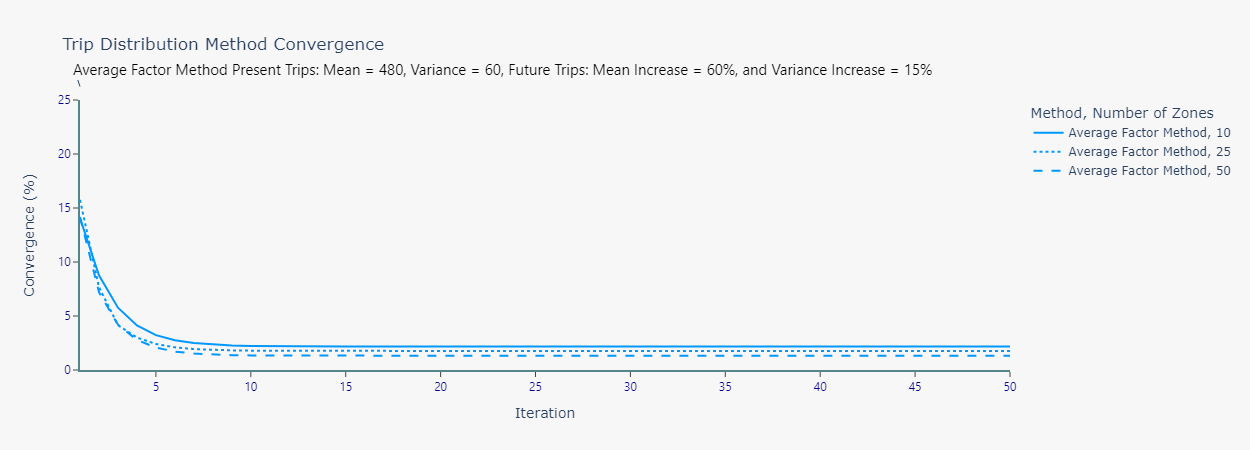

In [12]:
ded_test(dist_func='AFM', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=50)

<div class='alert alert-block alert-info' style='font-family: Helvetica; font-size:17px'><b>Summary:</b>

- From a practical viewpoint, the Average Growth Factor is best used as a pedagogic or diagnostic tool, or as part of a multi-step procedure.

- The simple algebra also makes it easy to trace and debug: you can compute cell-level contributions explicitly and produce sensitivity tables that show which origin–destination pairs drive most of the change.

- Finally, although the Average Growth Factor is fast and transparent, it is recommended treating its outputs as provisional. If meeting exact future row/column totals is required - as it usually is for downstream assignment and revenue calculations - one should follow it with a balancing method. In sum, use Average Growth Factor for quick diagnostics.
</div>

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.ii. Detroit method**</span>

In [13]:
# ded_test(dist_func='DM', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=50)

<div class='alert alert-block alert-info' style='font-family: Helvetica; font-size:17px'><b>Summary:</b>

- From an algorithmic perspective, Detroit has lesser iteration cost but can introduce bias into columns. If the planner’s downstream processes (e.g., assignment) are sensitive to attraction totals, applying Detroit alone without a follow-up balancing method may mislead results.

- Detroit method is a fast, origin-focused technique that must be used with awareness of its single-side constraint and its implications for attraction totals.
</div>

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.iii. Fratar method**</span>

In [14]:
# ded_test(dist_func='FM', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=50)

<div class='alert alert-block alert-info' style='font-family: Helvetica; font-size:17px'><b>Summary:</b>

- From an implementation viewpoint, Fratar method requires care in the iteration stopping rule: tight tolerances guarantee better margin matches but at higher computational expense and potential numerical sensitivity.

- For mid-sized matrices the method converges quickly; for sparse matrices or matrices with zero flows in important cells extra care is needed.

- Overall Fratar method is a practical, tried-and-tested technique and sits between single-step growth factor methods and more structurally explicit synthetic (gravity) models in terms of theoretical sophistication.
</div>

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.iv. Furness method**</span>

In [15]:
# ded_test(dist_func='FurM', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=50)

<div class='alert alert-block alert-info' style='font-family: Helvetica; font-size:17px'><b>Summary:</b>

- In practice, Furness method is commonly used when both production and attraction targets must be met exactly, for example for revenue forecasts, capacity planning, or assignment runs that require strict margin preservation.

- Its interpretability and mathematical properties make it attractive in professional practice. When using Furness method, best practice includes checking that the base matrix is a reasonable starting point, optionally regularizing tiny entries, and monitoring iteration diagnostics (maximum relative change in margins) to pick a sensible stopping rule.

- Furness method ubiquity is due to this blend of theoretical soundness, flexibility, and straightforward implementation.
</div>

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.v. Synthetic method (Impedance - Generation constrained)**</span>

In [16]:
# ded_test(dist_func='GMImp', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, gm_imp_mean=5000, gm_imp_var=150, gm_type='GEN',n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.vi. Synthetic method (Impedance - Attraction constrained)**</span>

In [17]:
# ded_test(dist_func='GMImp', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, gm_imp_mean=5000, gm_imp_var=150, gm_type='ATT', n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.vii. Synthetic method (Deterrence - Exponential cost function)**</span>

In [18]:
# ded_test(dist_func='GMDet', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, gm_det_func='Exponential',
#        gm_det_mean=5000, gm_det_var=150, gm_det_beta=0.05, gm_type='GEN', n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.viii. Synthetic method (Deterrence - Power cost function)**</span>

In [19]:
# ded_test(dist_func='GMDet', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, gm_det_func='Power',
#        gm_det_mean=5000, gm_det_var=150, gm_det_exp=1.5, gm_type='GEN', n_iter=50)

### <span style='font-family: Helvetica; font-size: 25px'>**V.A.ix. Synthetic method (Deterrence - Combined cost function)**</span>

In [20]:
# ded_test(dist_func='GMDet', n_zones=[10, 25, 50], test_pre_mean=480, test_pre_var=60, gm_det_func='Combined',
#        gm_det_mean=5000, gm_det_var=150, gm_det_exp=1.5, gm_det_beta=0.025, gm_type='GEN', n_iter=50)

## <span style='font-family: Helvetica; font-size: 25px'>**V.B. Simultaneous convergence testing**</span>

In [21]:
# conv_test(dist_func_arr=['AFM', 'GMImp', 'GMDet', 'DM', 'FM'], n_zones=[7,12], test_pre_mean=480, test_pre_var=60,
#           factor_fut_mean=0.6, factor_fut_var=0.15, n_iter=250,
#           gm_imp_mean=5000, gm_imp_var=150, gm_type=['ATT', 'GEN'],
#           gm_det_func=['Exponential', 'Combined'], gm_det_beta=0.1, gm_det_exp=1.25, gm_det_mean=5000, gm_det_var=150)

# <span style='font-family: Helvetica; font-size: 25px'>**VI. Summary**</span>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>After implementing and comparing all nine methods, several key patterns emerged. Growth factor methods generally performed well in scenarios with consistent future production and attraction totals. The Average Factor and Furness methods ensured matrix balance but sometimes took longer to converge.<br><br><strong>Synthetic methods, particularly the Impedance – Generation Constrained and Deterrence – Power Cost Function approaches, were the fastest to converge.</strong> Their reliance on cost-based decay functions made them more adaptable in scenarios without historical matrices. The generation-constrained impedance method reached convergence in fewer iterations than any other, making it especially useful for rapid planning assessments.<br><br>While growth factor methods benefit from historical continuity, they can be limited when future totals are inconsistent with base patterns. Synthetic methods, on the other hand, allow flexibility, especially in data-scarce environments, though their accuracy depends heavily on the impedance matrix and parameter choices.

</p>
</div>

# <span style='font-family: Helvetica; font-size: 25px'>**VII. Conclusion**</span>

<div style='text-align: justify'>
    <p style='font-family: Helvetica; font-size: 17px'>Trip distribution remains one of the most important components of travel demand modeling. This notebook explored both growth factor and synthetic methods in detail. Each method was examined through matrix logic, convergence evaluation, and discussion of advantages and limitations.<br><br><strong>Growth factor methods depend on available historical OD data and projected totals.</strong> These are suitable for regions with consistent travel patterns and long-term data availability. <strong>In contrast, synthetic methods offer a versatile, cost-based approach that can model trip interactions with limited prior data.</strong><br><br>The Impedance – Generation Constrained and Deterrence – Power Cost Function methods demonstrated the fastest convergence rates in this analysis, highlighting their computational efficiency. However, proper calibration and data quality remain crucial across all methods.<br><br><strong>By understanding the trade-offs and applications of each approach, planners and analysts can make informed decisions tailored to specific urban contexts and data environments.</strong></p>
</div>